In [236]:
# Bibliotecas

import pandas as pd
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.tokens import Doc
import stanza
import nltk
from nltk.corpus import stopwords  
from tqdm import tqdm
import re
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

import random
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nuno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nuno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nuno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1 Análise de Sentimento

### 1.1 Dados

amazon_reviews: Conjunto não balanceado, com cerca de 50000 reviews de produtos da empresa Amazon, anotadas com as etiquetas “positive” e “negative”.

In [293]:
import pandas as pd

# Carregar os dados de treino
train_data = pd.read_csv("amazon_reviews_train.csv")

# Carregar os dados de teste
test_data = pd.read_csv("amazon_reviews_test.csv")

In [238]:
# Verificar o tamanho dos dados
print(train_data.shape)
print(test_data.shape)

(48902, 2)
(2417, 2)


In [239]:
# Verificar os NA no conjunto de treino
print("Null values:",train_data.isnull().values.sum())
print("NA values:", train_data.isna().values.any())


# Verificar os NA no conjunto de teste
print("Null values:",test_data.isnull().values.sum())
print("NA values:", test_data.isna().values.any())

Null values: 0
NA values: False
Null values: 0
NA values: False


In [240]:
train_data.head()

,sentiment,review
0,negative,Product arrived labeled as Jumbo Salted Peanut...
1,positive,This is a confection that has been around a fe...
2,negative,If you are looking for the secret ingredient i...
3,positive,Great taffy at a great price. There was a wid...
4,positive,This saltwater taffy had great flavors and was...


In [241]:
# Número de documentos
num_docs_train = len(train_data)
num_docs_test = len(test_data)

print(f"Number of documents in training set: {num_docs_train}")
print(f"Number of documents in test set: {num_docs_test}")

# Distribuição de etiquetas
label_distribution_train = train_data['sentiment'].value_counts()
label_distribution_test = test_data['sentiment'].value_counts()

print("\nLabel distribution in training set:")
print(label_distribution_train)

print("\nLabel distribution in test set:")
print(label_distribution_test)

Number of documents in training set: 48902
Number of documents in test set: 2417

Label distribution in training set:
sentiment
positive    37835
negative    11067
Name: count, dtype: int64

Label distribution in test set:
sentiment
positive    1676
negative     741
Name: count, dtype: int64


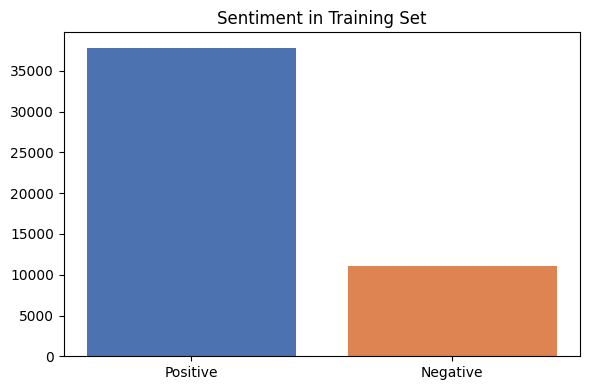

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('deep')

plt.figure(figsize=(6,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=train_data['sentiment'].value_counts(),
        color=colors[:2])
plt.title('Sentiment in Training Set')
plt.show()

Conjunto de treino não balanceado 

In [243]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Configura o undersampler
rus = RandomUnderSampler(random_state=42)

# Separa os dados e as etiquetas
X_train = train_data[['review']]
y_train = train_data['sentiment']

# Aplica o undersampling
X_res, y_res = rus.fit_resample(X_train, y_train)

# Verifica o novo balanceamento das classes
#print(pd.Series(y_res).value_counts())

# Criar um novo dataframe com os dados balanceados
train_data_balanced = pd.concat([X_res, pd.Series(y_res, name='sentiment')], axis=1)

print(train_data['sentiment'].value_counts())
print(train_data_balanced['sentiment'].value_counts())

sentiment
positive    37835
negative    11067
Name: count, dtype: int64
sentiment
negative    11067
positive    11067
Name: count, dtype: int64


### 1.2 Definição de um baseline usando ferramentas já existentes

- TextBlob
- Vader Sentiment
- Stanza

In [244]:
# Instalar biblioteca textblob
# !pip install textblob

In [245]:
# Instalar biblioteca vaderSentiment
# !pip install vaderSentiment

In [246]:
# Instalar biblioteca stanza
# !pip install stanza

In [247]:
# Bibliotecas
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# Verificar os nomes das colunas
print(test_data.columns)


# Função para prever o sentimento com TextBlob
def predict_sentiment(text):
    analysis = TextBlob(text)
    # TextBlob retorna polaridade dentro do intervalo [-1, 1], onde valores positivos indicam sentimentos positivos
    return "positive" if analysis.sentiment.polarity >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_TextBlob"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["sentiment"] = test_data["sentiment"].map({"positive": 1, "negative": 0})
test_data["predicted_sentiment_TextBlob"] = test_data["predicted_sentiment_TextBlob"].map({"positive": 1, "negative": 0})

print(test_data["sentiment"].value_counts())

# Calcular as métricas de avaliação
print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_TextBlob"] ))

Index(['sentiment', 'review'], dtype='object')


sentiment
1    1676
0     741
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       741
           1       0.77      0.94      0.85      1676

    accuracy                           0.76      2417
   macro avg       0.75      0.65      0.67      2417
weighted avg       0.76      0.76      0.74      2417



In [248]:
# Bibliotecas
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Inicializar o analisador de sentimentos VADER
analyzer = SentimentIntensityAnalyzer()


# Função para prever o sentimento com VADER
def predict_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return "positive" if scores["compound"] >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_VADER"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["predicted_sentiment_VADER"] = test_data["predicted_sentiment_VADER"].map({"positive": 1, "negative": 0})

print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_VADER"] ))

              precision    recall  f1-score   support

           0       0.82      0.39      0.53       741
           1       0.78      0.96      0.86      1676

    accuracy                           0.79      2417
   macro avg       0.80      0.68      0.70      2417
weighted avg       0.79      0.79      0.76      2417



In [249]:
# import pandas as pd
# import stanza
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# # Inicializar o pipeline NLP Stanza
# nlp = stanza.Pipeline("en", processors="tokenize,sentiment")


# # Função para prever o sentimento com Stanza
# def predict_sentiment(text):
#     doc = nlp(text)
#     sentiment_scores = [sentence.sentiment for sentence in doc.sentences]
#     avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
#     return "positive" if avg_sentiment >= 1 else "negative"


# # Aplicar a função de previsão de sentimento aos dados de teste
# test_data["predicted_sentiment_Stanza"] = test_data["review"].apply(predict_sentiment)

# # Converter rótulos de string para binários
# test_data["predicted_sentiment_Stanza"] = test_data["predicted_sentiment_Stanza"].map(
#     {"positive": 1, "negative": 0}
# )

# # Calcular as métricas de avaliação
# print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_Stanza"] ))

### 1.3 Preparação de dados e aplicação de um léxico de sentimentos

**Léxicos de polaridade** são recursos valiosos em processamento de linguagem natural (NLP), particularmente úteis para tarefas como análise de sentimentos, onde o objetivo é determinar a atitude ou emoção expressa em um texto. Esses léxicos consistem em listas de palavras, cada uma associada a uma pontuação ou etiqueta que indica se a palavra tem uma conotação positiva, negativa ou neutra. Alguns léxicos também incluem intensidades para refletir o grau de emoção. 

- NRC Word-Emotion Association Lexicon (EmoLex)

In [250]:
# Lista de palavras inglesas e o seu respetivo sentimento (positivo ou negativo)

emolex = pd.read_csv(
    "NCR-lexicon.txt",
    skiprows=0,
    sep="\t",
)

emolex = emolex[["English Word", "negative", "positive"]]

emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex.head(10)


,English Word,negative,positive
0,aback,0,0
1,abacus,0,0
2,abandon,1,0
3,abandoned,1,0
4,abandonment,1,0
5,abate,0,0
6,abatement,0,0
7,abba,0,1
8,abbot,0,0
9,abbreviate,0,0


In [251]:
emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex_dict['happy']

(1, 0)

- Afinn Lexicon ()

Este léxico atribui a cada palavra uma pontuação de -5 a 5, indicando a intensidade do sentimento negativo ou positivo. É útil em contextos onde a intensidade precisa ser medida.

In [252]:
afinn = pd.read_csv("Afinn.csv", encoding="latin1")

afinn.head(10)

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
5,abductions,-2
6,abhor,-3
7,abhorred,-3
8,abhorrent,-3
9,abhors,-3


In [253]:
afinn_dict = {row["word"]: row["value"] for index, row in afinn.iterrows()}

afinn_dict['happy']

3

- Bing Lexicon ()

Este léxico é frequentemente usado em análise de sentimentos para identificar e contar o número de palavras positivas e negativas em um texto.

In [254]:
bing = pd.read_csv("Bing.csv")

bing.head(10)

,word,sentiment
0,2-faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative
5,abominate,negative
6,abomination,negative
7,abort,negative
8,aborted,negative
9,aborts,negative


In [255]:
# Adiciona colunas binárias para os sentimentos
bing['negative'] = (bing['sentiment'] == 'negative').astype(int)
bing['positive'] = (bing['sentiment'] == 'positive').astype(int)

# Remove a coluna de sentimento
bing = bing.drop('sentiment', axis=1)

#bing.head(10)

bing_dict = {row["word"]: (row["positive"], row["negative"]) for index, row in bing.iterrows()}

bing_dict['happy']

(1, 0)

Pré-processamento

In [256]:
#!pip install wordcloud

**Wordclouds** testar no fim com os modelos e respetivo tratamento do texto

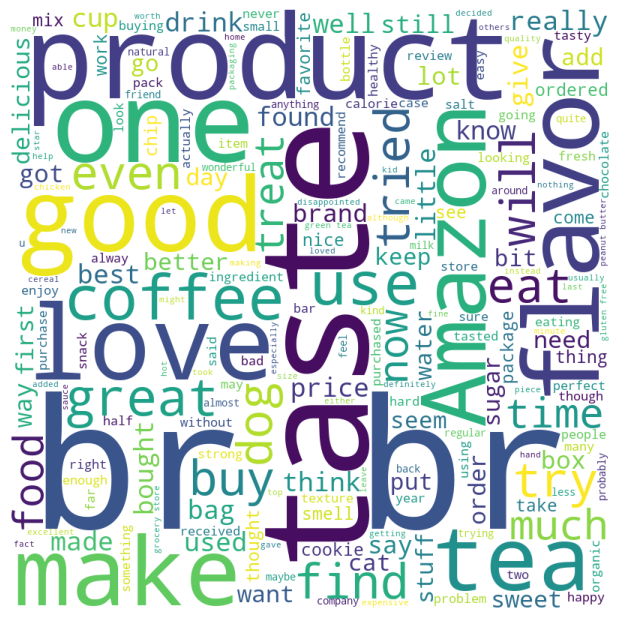

In [257]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatena todas as reviews em uma única string
text = " ".join(review for review in train_data['review'])

# Crie a instância WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

# Plote o WordCloud                    
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [258]:
from collections import Counter
import pandas as pd

# Top 20 palavras mais comuns
words = re.findall(r'\w+', ' '.join(train_data['review'].str.lower()))
top = Counter(words)
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,154572
1,i,142088
2,and,105446
3,a,100114
4,it,88910
5,to,82734
6,of,65062
7,is,59759
8,this,56492
9,br,48939


- Limpeza do texto

try and except: foi utilizado em quase todas as funções porque mais para a frente vamos fazer as combinações e por isso não vamos precisar sempre de tokenizar pois vai bastar uma vez, então se der erro ele apenas passa o text para o words. O words essencialmente nesses casos vai ser já a lista de tokens

In [259]:
import re


# Função de limpeza de texto
def clean(text):
    
    # Transformar em minúsculas
    text = text.lower()
    # Remover código HTML
    text = re.sub(r"<[^>]+>", "", text)
    # Remover URLs
    text = re.sub(r"http\S+|www\S+|https?\:\/\/\S+", "", text)
    # Remover menções a usuários (não comum em reviews da Amazon)
    text = re.sub(r"@\w+", "", text)
    # Remover hashtags (também não comum em reviews da Amazon)
    text = re.sub(r"#\w+", "", text)
    # Remover entidades HTML (&amp;, &lt;, etc.)
    text = re.sub(r"&\w+;", "", text)
    # Remover números (avaliações numéricas, preços, etc.)
    text = re.sub(r"\d+", "", text)
    # Substituir caracteres de pontuação por espaços
    text = re.sub(r"[^\w\s]", " ", text)
    # Remover espaços múltiplos e linhas novas
    text = re.sub(r"\s+", " ", text)
    #Remover espaços no início e no fim
    text = text.strip()

    return text


# train_clean = train_data["review"].apply(clean)
# test_clean = test_data["review"].apply(clean)


# train_clean.to_csv(
#    "/Users/marianaborralho/Desktop/M. Ciencia de Dados/2 Semestre/Text Mining/Trabalho/train_clean.csv",
#    index=False,
# )
# test_clean.to_csv(
#    "/Users/marianaborralho/Desktop/M. Ciencia de Dados/2 Semestre/Text Mining/Trabalho/train_clean.csv",
#    index=False,
# )

In [260]:
train_data["review"][157]

"Hi, I have to have black tea everyday. I have done it in the past 25 years and it's a habit of mine. Ahmad tea is one of my favorite brands and I highly recommend it if you like black tea. I think this is going to remain my favorite for the next 100 years or so :)"

In [261]:
# train_clean[157]

- Tokenização

In [262]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download("punkt")


# Função de tokenização
def tokenize(text):
    return word_tokenize(text)


# train_tok = train_data["review"].apply(tokenize)

# test_tok = test_data["review"].apply(tokenize)

[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [263]:
# train_tok[18]

- StopWords

In [264]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
import nltk

# Função que remove stopwords
def remove_stopwords(text):
    
    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [word for word in words if word not in nltk_stopwords.words('english')]
    return words

# train_stopwords = train_data["review"].apply(remove_stopwords)
# test_stopwords = test_data["review"].apply(remove_stopwords)

In [265]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [266]:
# train_stopwords[28]

- Stemming

In [267]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# Função de stemming
def stem(text):
    stemmer = PorterStemmer()
    try:
        words = word_tokenize(text)
    except:
        words = text
    words = [stemmer.stem(word) for word in words]
    return words

# train_stem = train_data['review'].apply(stem)
# test_stem = test_data['review'].apply(stem)


In [268]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [269]:
# train_stem[28]

- Lematização

In [270]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Função de lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [lemmatizer.lemmatize(word, "v") for word in words]
    return words

# train_lemmatized = train_data["review"].apply(lemmatize)
# test_lemmatized = test_data["review"].apply(lemmatize)

In [271]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [272]:
# train_lemmatized[28]

- Contrações

In [273]:
#!pip install contractions

In [274]:
import contractions

# Função que trata das contrações
def expand_contractions(text):
    return contractions.fix(text)


# train_expanded = train_data["review"].apply(expand_contractions)
# test_expanded = test_data["review"].apply(expand_contractions)

In [275]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [276]:
# train_expanded[28]    

- POS tagging (Part-of-Speech tagging)

Foram removidas 3 classes: Preposições, Conjunções e Pronomes

Nota: Algumas destas classes podem ser removidas usando a função de stopwords (são muito comuns e geralmente não contribuem muito para o significado de uma frase)

Ver se faz sentido adicionar/retirar alguma classe
    


In [277]:
def pos_tagging(text):
    
    
    try:
        words = word_tokenize(text)
    except:
        words = text
    
    # Aplica o POS tagging a cada palavra
    pos_tags = nltk.pos_tag(words)

    # Filtra palavras que são preposições (IN), conjunções (CC) ou pronomes (PRP, PRP$)
    filtered_words = [word for word, tag in pos_tags if tag not in ['IN', 'CC', 'PRP', 'PRP$']]

    # Junta as palavras filtradas de volta em uma string
    return filtered_words

# Exemplo 
#text_example = "The quick brown fox jumps over the lazy dog"
#filtered_text = pos_tagging(text_example)
#print(filtered_text)

# train_pos = train_data["review"].apply(pos_tagging)
# test_pos = test_data["review"].apply(pos_tagging)

In [278]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [279]:
# train_pos[18]

- Tratamento da Negação

**Paper**: Effect of Negation in Sentences on Sentiment Analysis and Polarity
Detection

In [280]:
from nltk.sentiment.util import mark_negation

# Função que trata da negação
def negation(tokens):
    try:
        tokens = word_tokenize(tokens)
    except:
        tokens = tokens
    return mark_negation(tokens)

# train_negation = train_data["review"].apply(negation)
# test_negation = test_data["review"].apply(negation)

In [281]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [282]:
# train_negation[18]

A função **mark_negation** da biblioteca NLTK anexa um sufixo '_NEG' a todas as palavras que aparecem após uma palavra de negação até a próxima pontuação. As palavras de negação padrão que a função considera são 'not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt', 'n’t'. A pontuação padrão que a função considera para terminar o uso de negação é '.', ':', ';', '!', '?'.

**Problema**: Não considera a virgula como pontuação

In [283]:
from nltk.tokenize import word_tokenize
import contractions

# Função Função que identifica e marca negações sintáticas
def mark_syntactic_negation(text):

    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        # Process each item in the list if it's a string
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        # Flatten the list of tokens if there are nested lists
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]

    negation_words = ['not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt']
    punctuation = ['.', ':', ';', '!', '?', ',']  
    suffixed = []
    neg_scope = False

    for token in tokens:
        if token in negation_words:
            neg_scope = True
            suffixed.append(token)
            continue

        if token in punctuation:
            neg_scope = False

        if neg_scope:
            token = "NOT_" + token 

        suffixed.append(token)

    return suffixed

#train_syntactic_negation = train_data["review"].apply(mark_syntactic_negation)
#test_syntactic_negation_ = test_data["review"].apply(mark_syntactic_negation)

In [284]:
train_data["review"][6]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [285]:
# train_syntactic_negation[6]

In [286]:
import re
from nltk.tokenize import word_tokenize

# Função que identifica e marca negações morfológicas
def mark_morphological_negation(text):
    
    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        # Process each item in the list if it's a string
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        # Flatten the list of tokens if there are nested lists
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]
        
    negation_prefixes = ['ab','il','ir','un', 'in', 'im', 'dis', 'non']
    suffixed = []

    for token in tokens:
        if any(token.startswith(prefix) for prefix in negation_prefixes):
            # Marcar o token com um sufixo especial para indicar a negação
            token = "NOT_" + token
        suffixed.append(token)

    return suffixed

# Exemplo
example_text = "It is uncommon for disorganized plans to succeed."
processed_text = mark_morphological_negation(example_text)
print(processed_text)


#train_morphological_negation = train_data["review"].apply(mark_morphological_negation)
#test_morphological_negation_ = test_data["review"].apply(mark_morphological_negation)

['it', 'is', 'NOT_uncommon', 'for', 'NOT_disorganized', 'plans', 'to', 'succeed', '.']


In [287]:
train_data['review'][0]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [288]:
# train_morphological_negation[0]

- Classificação final a atribuir ao texto

**ideia geral:** quantificar quantas palavras do texto a analisar estão classificadas como Positive e Negative e, consoante a classe mais frequente, decidir qual a classificação final a atribuír ao texto.

In [289]:
def count_sentiment_words(tokens, lexicon):
    # Initialize counters
    counts = {"positive": 0, "negative": 0}
    not_found_words = set()  # Use set for O(1) lookups

    last_sentiment = None  # Tracks the last sentiment found
    
    for token in tokens:
        if token in lexicon:
            positive_score, negative_score = lexicon[token]
            counts["positive"] += positive_score
            counts["negative"] += negative_score
            
            # Update the last sentiment observed
            if positive_score > negative_score:
                last_sentiment = "positive"
            elif negative_score > positive_score:
                last_sentiment = "negative"
        elif '_NEG' in token:
            counts["negative"] += 3
            last_sentiment = "negative"
        else:
            not_found_words.add(token)  # Add the word to the set
    
    not_found_percentage = (len(not_found_words) / len(tokens)) * 100
    
    # Determine the overall sentiment
    if counts["positive"] > counts["negative"]:
        sentiment = "positive"
    elif counts["negative"] > counts["positive"]:
        sentiment = "negative"
    else:
        # Strategy for ties: use the sentiment of the last word with sentiment
        sentiment = last_sentiment if last_sentiment else random.choice(["positive", "negative"])
    
    return sentiment, list(not_found_words), not_found_percentage

In [290]:
def count_sentiment_words_Afinn(tokens, lexicon):
    
    counts = 0
    counter_not_found = 0
    not_found_words = []  # Lista para armazenar palavras não encontradas no léxico
    last_sentiment = None  # Acompanha o último sentimento encontrado
    
    
    for token in tokens:
        if token in lexicon:
            score = lexicon[token]
            counts += score
            
            # Atualiza o último sentimento observado
            if score > 0:
                last_sentiment = "positive"
            elif score < 0:
                last_sentiment = "negative"
        elif '_NEG' in token:
            counts -= 5
            last_sentiment = "negative"    
        else:
            counter_not_found += 1
            not_found_words.append(token)  # Adiciona a palavra à lista de não encontradas
            
    total_tokens = len(tokens)
    not_found_percentage = (counter_not_found / total_tokens) * 100
    
    # Determina o sentimento geral
    if counts > 0:
        sentiment = "positive"
    elif counts < 0:
        sentiment = "negative"
    else:
        # Estratégia de desempate: usa o último sentimento observado
        if last_sentiment:
            sentiment = last_sentiment
        else:
            # Se não houve palavras com sentimento detectado, escolhe aleatoriamente
            sentiment = random.choice(["positive", "negative"])  # Ou outra estratégia padrão
    
    return sentiment, not_found_words, not_found_percentage

In [291]:
def calculate_accuracy(data, actual_col, predicted_col, not_found_col):

    correct_predictions = data[data[actual_col] == data[predicted_col]]
    accuracy = len(correct_predictions) / len(data) * 100
    not_found_average = data[not_found_col].mean()  # Calcula a média de percentagens de palavras não encontradas
    return accuracy, not_found_average

Ideia geral: queremos testar todas as combinações quer seja com os diferentes lexicos como os metodos de processamento. Clean e Expand Contractions serão sempre os primeiros metodos a ser aplicados pois não é preciso ser tokenizado.

- Diferentes combinacoes de pre process text

In [294]:
import itertools
from tqdm import tqdm # Barra de progresso

# Lista de métodos de processamento de texto
methods = [clean, expand_contractions, mark_morphological_negation, mark_syntactic_negation, pos_tagging, remove_stopwords, lemmatize, stem]
    
# Dicionário de léxicos
lexicon_names = {'afinn_dict': afinn_dict, 'bing_dict': bing_dict, 'emolex_dict': emolex_dict}

final_combinations = []

# Combina métodos individualmete
for method in methods:
    final_combinations.append((method,))

# Combina 2 métodos
for (method1, method2) in itertools.combinations(methods, 2):
    final_combinations.append((method1, method2))

# Combina 3 métodos
for combination in itertools.combinations(methods, 3):
    final_combinations.append(combination)

# Combina 4 métodos
for combination in itertools.combinations(methods, 4):
    final_combinations.append(combination)

# Combina 5 métodos
for combination in itertools.combinations(methods, 5):
    final_combinations.append(combination)

# Combina 6 métodos
for combination in itertools.combinations(methods, 6):
    final_combinations.append(combination)

# Combina todos os métodos
for combination in itertools.combinations(methods, 7):
    final_combinations.append(combination)


# Verifica se os métodos 'clean' e 'expand_contractions'estão na ordem correta quando aplicável e evita que incluam combinações com 
# lemmatize e stem em simultâneo
new_combinations = []
for combination in final_combinations:
    if clean in combination and expand_contractions in combination or clean in combination or expand_contractions in combination:
        if clean in combination and combination.index(clean) == 0:
            new_combinations.append(combination)
        elif expand_contractions in combination and combination.index(expand_contractions) == 0:
            new_combinations.append(combination)
        elif clean in combination and expand_contractions in combination and combination.index(clean) == 0 and combination.index(expand_contractions) == 1:
            new_combinations.append(combination)
        else:
            continue
    if lemmatize in combination and stem in combination:
        continue
    elif mark_morphological_negation and mark_syntactic_negation in combination:
        continue
    elif mark_morphological_negation and expand_contractions in combination:
        continue
    elif mark_syntactic_negation and expand_contractions in combination:
        continue
    else:
        new_combinations.append(combination)

final_combinations = new_combinations
#Verifica duplicados
#print(len(final_combinations))
final_combinations = list(set(final_combinations))
#print(len(final_combinations))

lexicons = list(lexicon_names.keys())
final_combinations = list(itertools.product(final_combinations, lexicons))

results = []

for combo in tqdm(final_combinations, desc='Processing combinations', unit='combo'):

    combo_data = test_data.copy() # Cópia dos dados de teste
    # Aplica métodos de processamento de texto
    text_processing_methods = combo[0]

    for method in text_processing_methods:
        combo_data['review'] = combo_data['review'].apply(method)

    # Aplica o léxico escolhido
    lexicon_name = combo[1]
    lexicon = lexicon_names[lexicon_name]
    
    if lexicon == afinn_dict:
        # Função específica para AFINN
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(word_tokenize(review), lexicon)
            ).apply(pd.Series)
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(review, lexicon)
            ).apply(pd.Series)
    else:
        # Função geral para outros léxicos
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(word_tokenize(review), lexicon)
            ).apply(pd.Series)
    
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(review, lexicon)
            ).apply(pd.Series)

        
    accuracy, not_found_average = calculate_accuracy(combo_data, 'sentiment', 'sentiment_predicted', 'not_found_percentage')
    
    report_dict = classification_report(combo_data['sentiment'], combo_data['sentiment_predicted'], output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

     # Combina métricas do relatório de classificação com outros resultados e adicionar à lista de resultados
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_methods]), lexicon_name),
        'accuracy': accuracy,
        'not_found_average': not_found_average,
        **report_metrics  # Desempacota as métricas do relatório de classificação
    })
    
# Converte resultados em DataFrame
results_df = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_df.to_csv("text_processing_combinations_results.csv", index=False)

Processing combinations:   3%|▎         | 20/642 [01:54<1:25:57,  8.29s/combo]

In [ ]:
# Se quisermos executar algum método individualmente temos esta forma   

test_data[['sentiment_predicted_tokenized_cleaned_expand_remove_stem', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words(stem(pos_tagging(expand_contractions(clean(review)))), emolex_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_tokenized_cleaned_expand_remove_stem', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")


print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_tokenized_cleaned_expand_remove_stem"] ))



In [55]:
#Executa métodos individualmente

from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report


test_data[['sentiment_predicted_tokenized_cleaned', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words_Afinn(mark_syntactic_negation(pos_tagging(expand_contractions(clean(review)))), afinn_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_tokenized_cleaned', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")


print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_tokenized_cleaned"] ))


Average percentage of not found words: 93.78035204956839%
              precision    recall  f1-score   support

    negative       0.58      0.49      0.53       741
    positive       0.79      0.84      0.81      1676

    accuracy                           0.73      2417
   macro avg       0.68      0.66      0.67      2417
weighted avg       0.72      0.73      0.73      2417



In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report


test_data[['sentiment_predicted_tokenized_cleaned', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words(word_tokenize(clean(review)), bing_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_tokenized_cleaned', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")


print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_tokenized_cleaned"] ))

### O que falta para ficar finalizado ate ao ponto 1.3



- Léxicos: procurar alguma bibliografia que reporte a utilização de léxicos de polaridade por forma a decidir qual a melhor abordagem
- Fazer alguma coisa em relacao aos tokens que nao sao encontrados dentro do dicionario 
- Experimentar as diferentes combinacoes de pre process text (stemming, lemmatization, stopwords, etc) 
(Juntar resultados num dataframe e exportar para csv)


### 4 Treino de um modelo (aprendizagem automática)

1ª Abordagem mais simples

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', analyzer=stem)

X = tfidf_vectorizer.fit_transform(train_data_balanced['review'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data_balanced['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report) 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Accuracy: 0.8604987350921576
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2782
           1       0.87      0.84      0.86      2752

    accuracy                           0.86      5534
   macro avg       0.86      0.86      0.86      5534
weighted avg       0.86      0.86      0.86      5534



## 4 Treino de um modelo (aprendizagem automática)

Nesta seção, abordaremos o processo de treinar um modelo de aprendizagem automática com o objetivo de melhorar o desempenho da classificação de dados. Seguiremos os seguintes passos:

## 4.1 Treinamento do Modelo

1. Selecione uma ferramenta de classificação adequada, como **scikit-learn**, TensorFlow, PyTorch, etc.
2. Prepare os dados de treino, garantindo que estão devidamente limpos e formatados para o processo de treinamento.
3. Configure e treine o modelo com o conjunto de dados de treino.

    - Várias configurações podem ser testadas:
        - Número de features.
        - Tratamento de maiúsculas e minúsculas.
        - Diferentes métodos de pré-processamento de texto (normalização, stemming, lematização, etc.).
        - Inclusão ou exclusão de informações de part-of-speech tagging.
        - Utilização de entidades nomeadas reconhecidas no texto.
        - Incorporação de embeddings pré-treinados, como GloVe.
        - Se houver desbalanceamento de classes usar 

## 4.2 Avaliação do Modelo

1. Aplique o modelo treinado ao conjunto de dados de teste.
2. Avalie o desempenho do modelo utilizando métricas adequadas, como precisão, recall, F1-score, etc.
3. Compare os resultados obtidos com os do modelo anterior para avaliar as melhorias.

## 4.3 Documentação e Experimentação

- Realize experimentos variados para entender o impacto de diferentes features e técnicas de pré-processamento.
- Documente cada experimento, incluindo a configuração usada e os resultados obtidos.
- Registre observações e conclusões relevantes a cada experimento.

## 4.4 Referências

- Alguns links que podem ajudar nesta tarefa 
    - https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews#Extracting-Features-from-Cleaned-reviews
    - https://github.com/jesseqzhen/NLP_Sentiment_Analysis
    - https://www.kaggle.com/code/yacharki/binary-classification-amazon-reviews-84-lstm
    - https://www.kaggle.com/code/mammadabbasli/amazon-reviews-analysis-logisticregression

## 5 Utilização de transformadores para classificação

- https://medium.com/@minamehdinia213/fine-tunning-bert-model-for-amazon-product-review-and-deploying-it-into-hugging-face-model-hub-7d259839d556

A aplicação de modelos pré-treinados baseados em transformadores representa uma técnica poderosa no campo da aprendizagem automática, especialmente para tarefas de classificação de texto. O processo será dividido em duas etapas principais, conforme descrito a seguir:

## 5.1 Experimentação com Pipelines Pré-definidos

1. Escolha um ou mais modelos baseados em transformadores disponíveis, como BERT, GPT, Transformer-XL, etc.
2. Utilize pipelines pré-definidos oferecidos por bibliotecas como Hugging Face's Transformers para aplicar rapidamente o modelo aos seus dados.
   
    Exemplos de comandos de pipelines podem incluir:
    
    ```python
    from transformers import pipeline
    classifier = pipeline('text-classification', model='bert-base-uncased')
    ```
    
3. Avalie o desempenho desses modelos em seu conjunto de dados sem qualquer ajuste adicional, usando métricas padrão de classificação.

## 5.2 Fine-tuning de um Modelo Pré-treinado

1. Selecione um modelo pré-treinado apropriado para o seu conjunto de dados e a tarefa de classificação em questão.
2. Adapte o modelo ao seu conjunto de dados específico, o que é conhecido como fine-tuning. Isso envolve o treinamento do modelo em seu conjunto de dados, ajustando os pesos do modelo pré-treinado para melhor se adequar à sua tarefa específica.
3. Durante o fine-tuning, experimente com diferentes hiperparâmetros, como taxa de aprendizado, número de épocas, tamanho do lote e outros relevantes para o modelo escolhido.
   
    Exemplo de código para fine-tuning:
    
    ```python
    from transformers import BertForSequenceClassification, Trainer, TrainingArguments
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    training_args = TrainingArguments(output_dir='./results', num_train_epochs=3, ...)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    
    trainer.train()
    ```
    
4. Após o fine-tuning, avalie novamente o modelo em seu conjunto de dados, usando as mesmas métricas de classificação para comparar o desempenho com o modelo antes do ajuste.